In [9]:
import json
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np

In [26]:
model1_path = '/Users/momiradzemovic/temp_data/perfect-detector#end_to_end_akf.json'
model1_name = 'AKF'

model2_path = '/Users/momiradzemovic/temp_data/RNNODE-lasot-exp25-128dim-no-occ-no-oov-jack-of-all-trades#perfect-detector#end_to_end_node.json'
model2_name = 'RNNODE'

with open(model1_path, 'r', encoding='utf-8') as f:
    model1_data = json.load(f)

with open(model2_path, 'r', encoding='utf-8') as f:
    model2_data = json.load(f)

def extract_stats(data: dict) -> dict:
    return data['global']

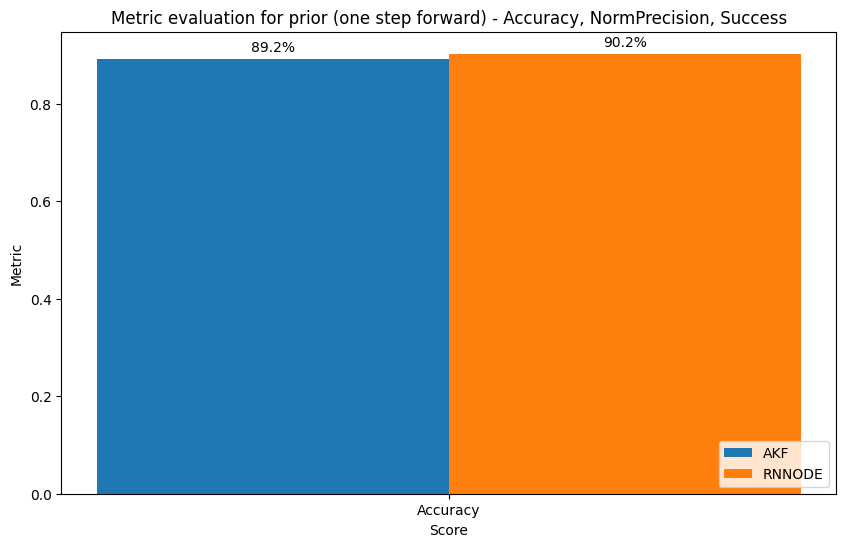

In [27]:
def show_compare_global_metrics(
    m1_data: dict,
    m1_name: str,
    m2_data: dict,
    m2_name: str,
    metrics: List[str],
    metric_format: str,
    title: str,
    ax: Optional[plt.Axes] = None,
    percentage: bool = False,
    bar_fontsize: int = 10
) -> None:
    def annotate_bars(bs):
        for bar in bs:
            height = bar.get_height()
            text = f'{100*height:.1f}%' if percentage else f'{height:.1E}'
            ax.annotate(text, xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=bar_fontsize)

    m1_prior = [m1_data[metric_format.format(metric_name)] for metric_name in metrics]
    m2_prior = [m2_data[metric_format.format(metric_name)] for metric_name in metrics]

    index = np.arange(len(metrics))
    bar_width = 0.35

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    b1 = ax.bar(index, m1_prior, bar_width, label=m1_name)
    b2 = ax.bar(index+bar_width, m2_prior,bar_width, label=m2_name)

    for b in [b1, b2]:
        annotate_bars(b)

    ax.set_xlabel('Score')
    ax.set_ylabel('Metric')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend(loc='lower right')


show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['Accuracy'],
    metric_format='prior-{}-0',
    title='Metric evaluation for prior (one step forward) - Accuracy, NormPrecision, Success',
    percentage=True
)
plt.show()

Osnovne informacije o skupu podataka: LaSOT ima 70 kategorija (+dodatnih 15 samo za test) sa po 20 sekvenci gde svaka sekvenca ima duzinu oko 2.5k. To je ukupno oko 3.5M slika (300-500GB). Za podelu skupa na treniranje i testiranje se koristi predefinisana podela koja ide uz skup podataka.

Osnovne informacije o KF modelu: Ovo je baseline model AKF (Adaptive Kalman Filter - koristi heuristiku). Na podskupu podatak sa 5 kategorija je dotreniran AKF imao poboljsanje oko 2% na Accuracy.

Osnovne informacije o RNNODE modelu: Kao enkoder koristi rekurentnu mrezu (brze se treniran, ali testiracu i ODE-RNN varijantu). Za dekoder se koristi ODE za ektrapolaciju (kao i kod ODE-RNN). Model je treniran da daje predikciju 5 koraka unapred i treniran je sa GaussianNLLoss loss funkcijom, ali bez regularzije. Treniran je generalni model - jedan model za sve kategorije.

Osnovne informacije o evaluaciji: U evaluaciji su preskoceni delovi sekvence gde vazi OCC (occlusion) ili OOV (out of view). Prvo sam ukljucio i OCC delove, ali sam onda uvideo da anotacije nisu dobre (cak i kad je ocigledno gde se skriveni objekat nalazi). Provericu tacno kako oni evaluiraju (kod je u Matlabu).

- Trenutno se ne gleda posterior, jer nije ukljucen detektor ili simuliran sum.
- Za jedan korak unapred je RNNODE bolji po svakoj metrici:
    - za 4% po Accuracy (prosecan IOU)
    - za 0.2% po NormPrecision (rastojanje centra bbox-a manje od neke granice - AUC)
    - za 3.7% po Success (IOU veci od neke granice - AUC)

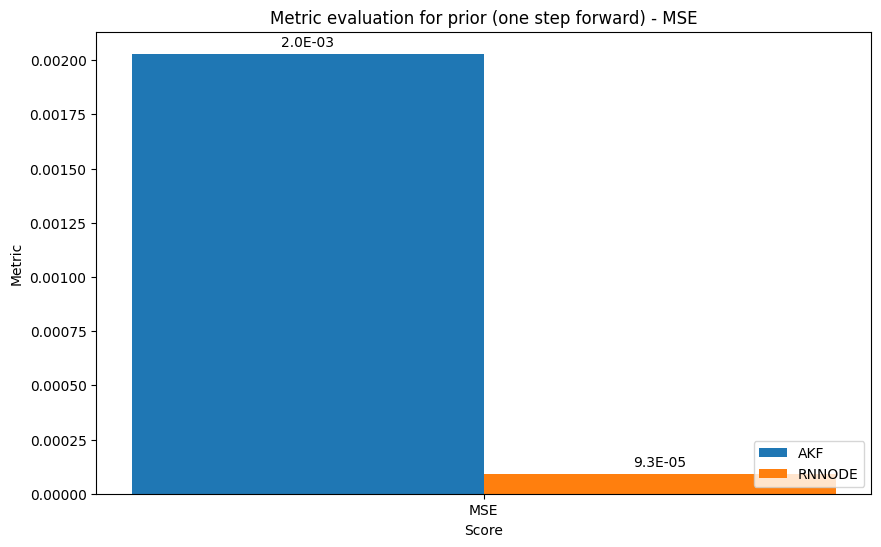

In [28]:
show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['MSE'],
    metric_format='prior-{}-0',
    title='Metric evaluation for prior (one step forward) - MSE',
    percentage=False
)
plt.show()

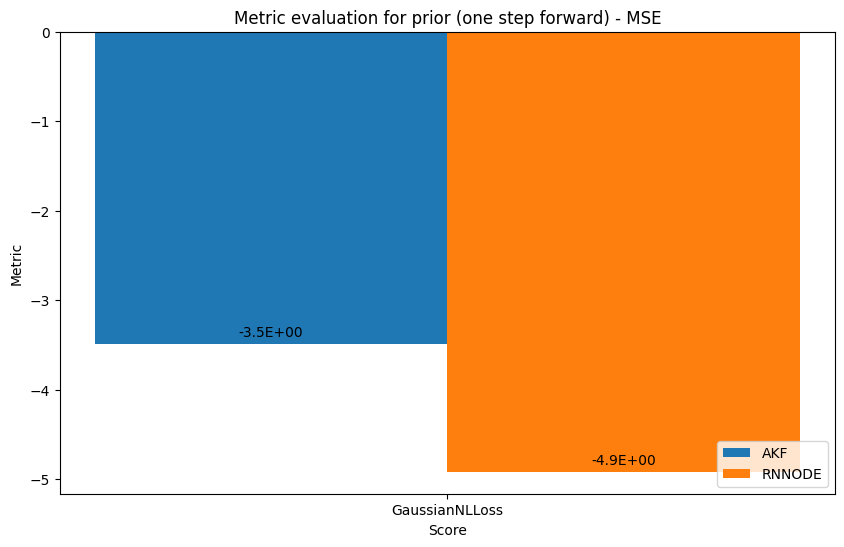

In [29]:
show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['GaussianNLLoss'],
    metric_format='prior-{}-0',
    title='Metric evaluation for prior (one step forward) - MSE',
    percentage=False
)
plt.show()

Po MSE za jedak korak unapred je razlika drasticna (3 puta). Nazalost, ova razlika se ne preslikava na ostale metrike. Postoje alternativne loss funckije za regresiju koje smanjuju ovu razliku (generalizovani IOU). Interesantno je da je ovde MSE za tri reda veci od MOT20 skupa podataka. To govori o tezini problema izmedju ova dva skupa (iz ugla modela kretanja).

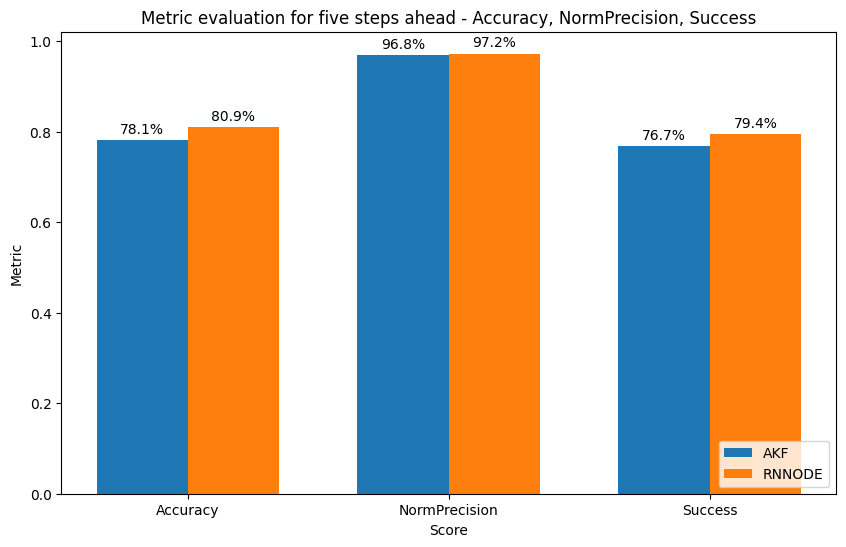

In [36]:
show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['Accuracy', 'NormPrecision', 'Success'],
    metric_format='prior-{}',
    title='Metric evaluation for five steps ahead - Accuracy, NormPrecision, Success',
    percentage=True
)
plt.show()

Za 5 koraka unapred (podaci nisu poznati za tih 5 koraka), odnosi ostaju slicni kao i za jedan korak.

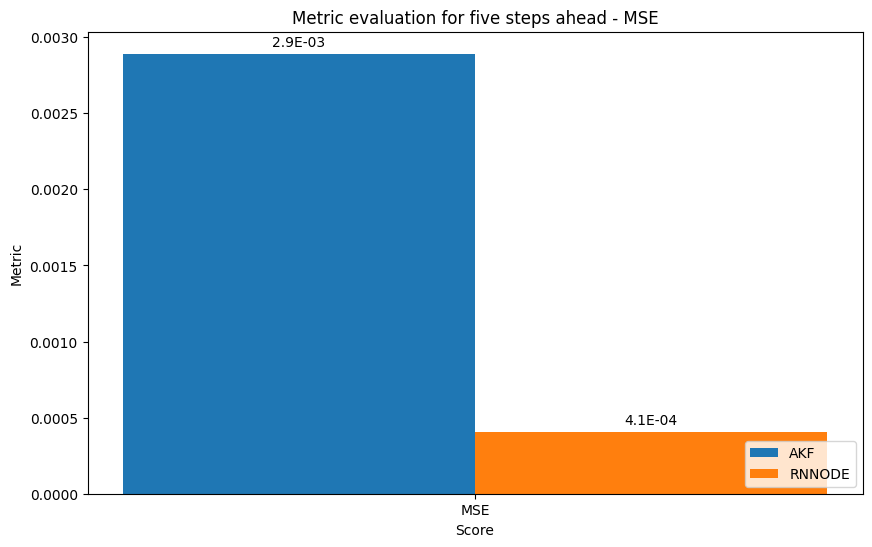

In [37]:
show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['MSE'],
    metric_format='prior-{}',
    title='Metric evaluation for five steps ahead - MSE',
    percentage=False
)
plt.show()

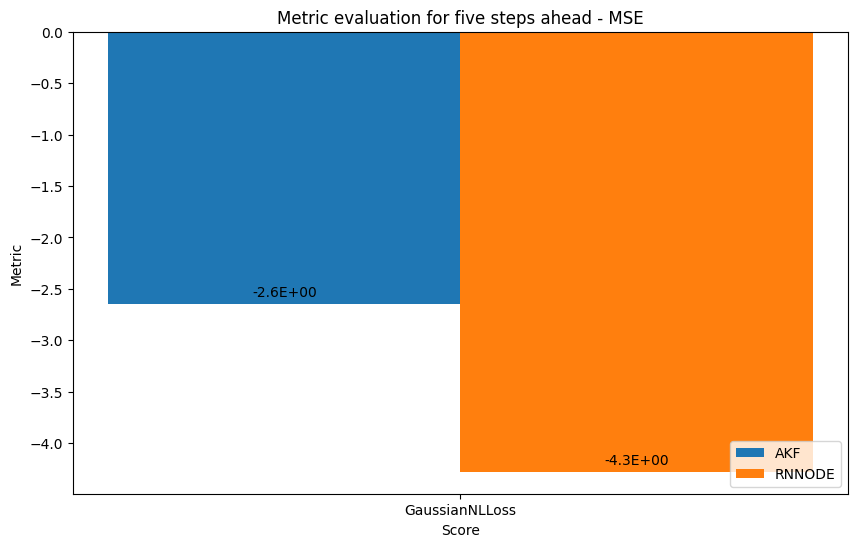

In [39]:
show_compare_global_metrics(
    m1_data=extract_stats(model1_data),
    m1_name=model1_name,
    m2_data=extract_stats(model2_data),
    m2_name=model2_name,
    metrics=['GaussianNLLoss'],
    metric_format='prior-{}',
    title='Metric evaluation for five steps ahead - MSE',
    percentage=False
)
plt.show()

Za 5 koraka unapred se smanjio odnos u MSE.

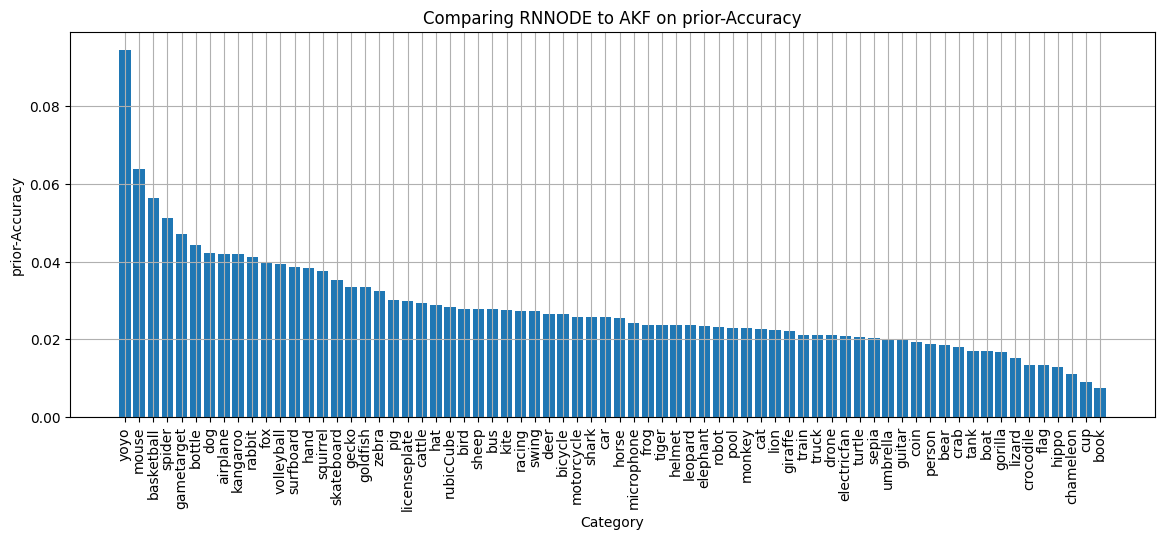

In [38]:
def plot_stats_diff(
    m1_data: dict,
    m1_name: str,
    m2_data: dict,
    m2_name: str,
    metric_name: str,
    relative: bool = False,
    reverse: bool = False
) -> None:
    categories = list(m1_data['categories'].keys())
    assert len(categories) == 70
    if relative:
        cmp_func = (lambda x, y: x / y) if not reverse else (lambda x, y: y / x)
    else:
        cmp_func = (lambda x, y: x - y) if not reverse else (lambda x, y: y - x)

    stats_diff = [(c, cmp_func(m2_data['categories'][c][metric_name], m1_data['categories'][c][metric_name])) for c in categories]
    stats_diff = sorted(stats_diff, reverse=True, key=lambda x: x[1])
    categories, acc_diff = zip(*stats_diff)

    plt.figure(figsize=(14, 5))
    plt.xlabel('Category')
    plt.ylabel(metric_name)
    plt.title(f'Comparing {m2_name} to {m1_name} on {metric_name}'
              + ('' if not relative else ' (relative/division)')
              + ('' if not reverse else ' (reverse)'))
    plt.grid()
    plt.bar(categories, acc_diff)
    plt.xticks(rotation=90)
    plt.show()

plot_stats_diff(model1_data, model1_name, model2_data, model2_name, 'prior-Accuracy')

Na grafiku je prestavljena razlika u tacnosti za 5 koraka unapred izmedju RNNODE i KF. Za 5 koraka unapred je RNNODE bolje od KF u svakoj kategoriji sem za kategoriju "train". Za neke klase kao sto je "yoyo" je razlika drasticna.

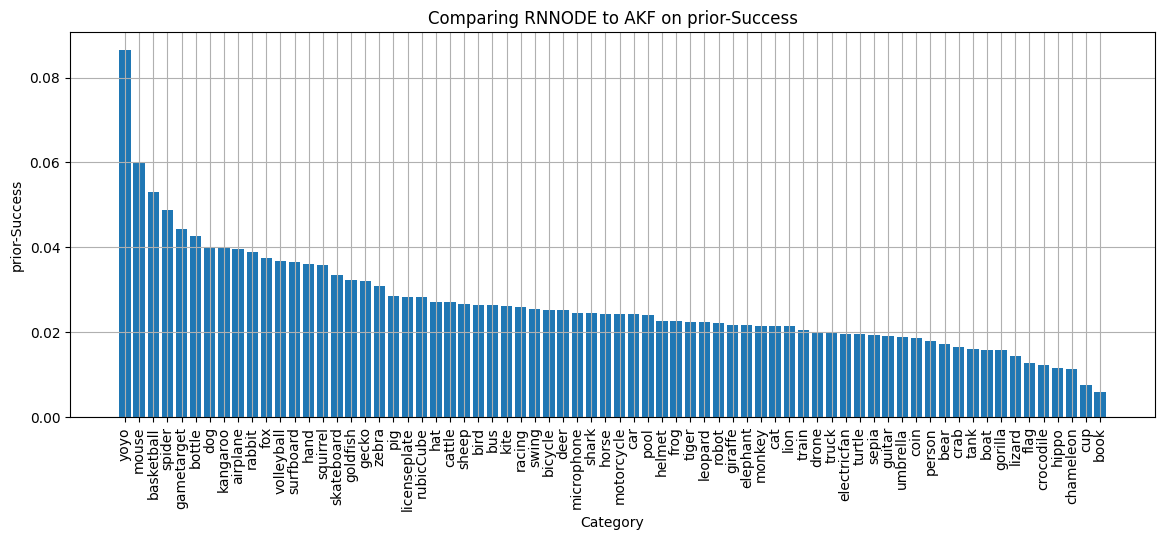

In [33]:
plot_stats_diff(model1_data, model1_name, model2_data, model2_name, 'prior-Success')

Na grafiku je prestavljena razlika u uspesnosti za 5 koraka unapred izmedju RNNODE i KF. Za 5 koraka unapred je RNNODE bolje od KF u svakoj kategoriji sem za kategoriju "train".

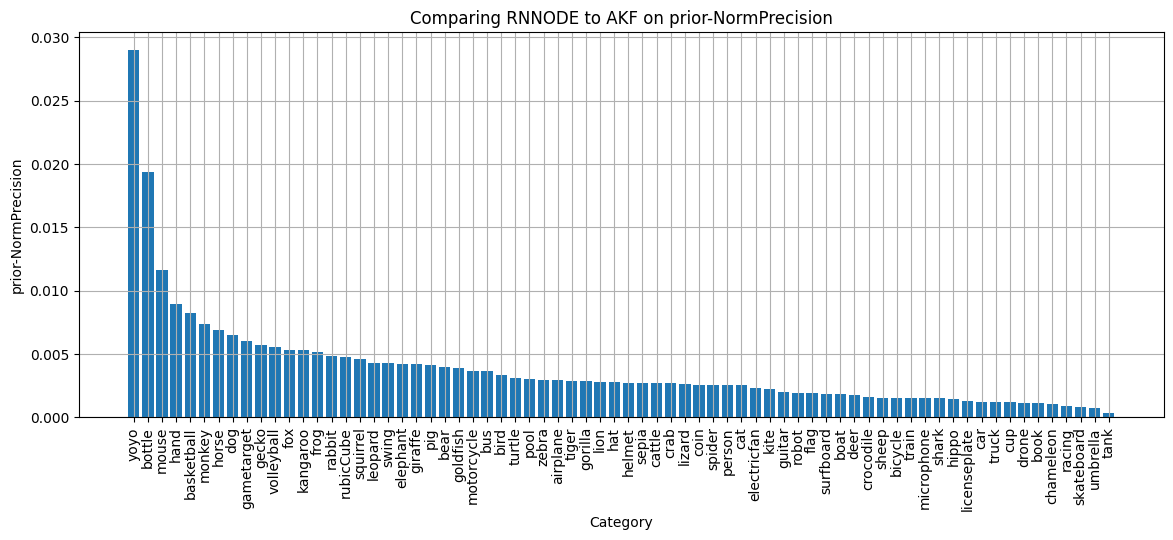

In [34]:
plot_stats_diff(model1_data, model1_name, model2_data, model2_name, 'prior-NormPrecision')

Na grafiku je prestavljena razlika u preciznosti za 5 koraka unapred izmedju RNNODE i KF. Za 5 koraka unapred je RNNODE bolje od KF u svakoj kategoriji.

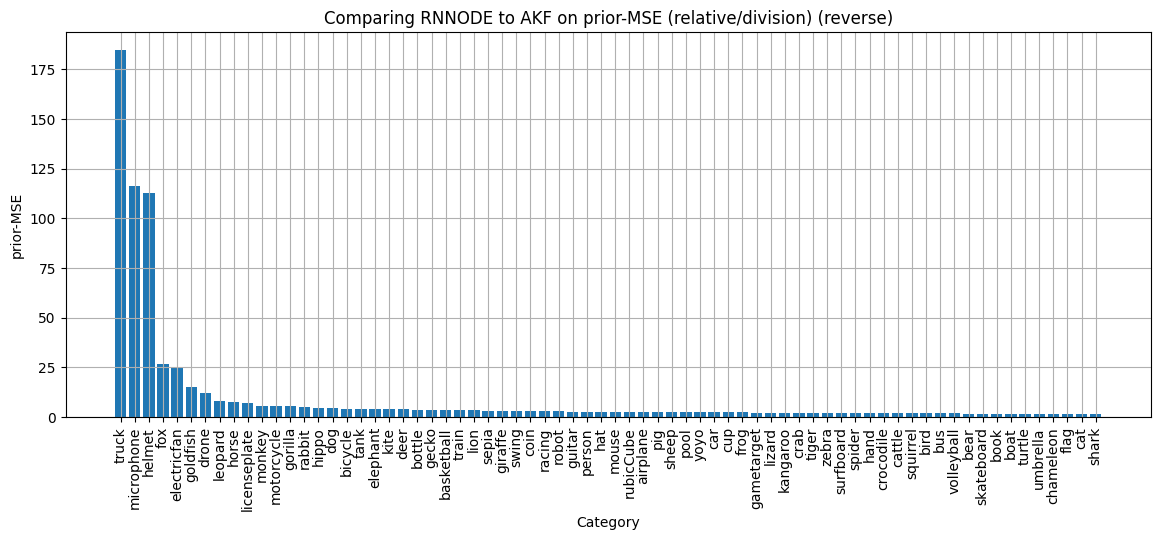

In [35]:
plot_stats_diff(model1_data, model1_name, model2_data, model2_name, 'prior-MSE', relative=True, reverse=True)

Na grafiku je prestavljen odnos u MSE za 5 koraka unapred izmedju KF i RNNODE. Za 5 koraka unapred je RNNODE bolje od KF u svakoj kategoriji sem za kategoriju "car". Interesantno je da je po MSE RNNODE bolji za nekih 40% iako je losiji po Accuracy i Success.